### MavenMegaMart Project
We will be working with the transactions, product, and hh_demographic tables in the 'data' folder.

The transaction table:
* First, read in the transactions data.
* Read in the columns household_key, basket_id, STORE_ID, DAY, QUANTITY, and SALES_VALUE.
* Convert DAY, QUANTITY, and STORE_ID to the smallest appropriate integer type.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path = "data/project_transactions.csv"
cols = ["household_key", "BASKET_ID", "DAY", "PRODUCT_ID", "QUANTITY", "SALES_VALUE"]
dtypes = {
    "DAY": "Int64",
    "QUANTITY": "Int32",
    "STORE_ID": "Int32"
}
# store the data into transaction dataframe
transactions = pd.read_csv(path, dtype=dtypes, usecols=cols)

In [4]:
transactions

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE
0,1364,26984896261,1,842930,1,2.19
1,1364,26984896261,1,897044,1,2.99
2,1364,26984896261,1,920955,1,3.09
3,1364,26984896261,1,937406,1,2.50
4,1364,26984896261,1,981760,1,0.60
...,...,...,...,...,...,...
2146306,1598,42305362535,711,92130,1,0.99
2146307,1598,42305362535,711,114102,1,8.89
2146308,1598,42305362535,711,133449,1,6.99
2146309,1598,42305362535,711,6923644,1,4.50


In [5]:
transactions.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146311 entries, 0 to 2146310
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   household_key  int64  
 1   BASKET_ID      int64  
 2   DAY            Int64  
 3   PRODUCT_ID     int64  
 4   QUANTITY       Int32  
 5   SALES_VALUE    float64
dtypes: Int32(1), Int64(1), float64(1), int64(3)
memory usage: 94.2 MB


we have 94.2 MB data which is much smaller than our original data. so, we're readig the data we need.

In [6]:
# create Date column based of the value of "DAY" and streem from 2016
# then drop the 'Day' column
transactions = transactions.assign(
    Date = (pd.to_datetime("2016", format='%Y')
    + pd.to_timedelta(transactions["DAY"].sub(1).astype(str) + ' days'))
).drop(["DAY"], axis=1)

In [7]:
transactions.head()

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,Date
0,1364,26984896261,842930,1,2.19,2016-01-01
1,1364,26984896261,897044,1,2.99,2016-01-01
2,1364,26984896261,920955,1,3.09,2016-01-01
3,1364,26984896261,937406,1,2.50,2016-01-01
4,1364,26984896261,981760,1,0.60,2016-01-01


### Time Based Analysis
* Plot the sum of sales by month. Are sales growing over time?
* Plot the same series after filtering down to dates April 2016 and October 2017.
* Plot the sum of monthly sales in 2016 vs the monthly sales 2017.
* Finally, plot total sales by day of week.

Text(0.5, 1.0, 'Sales by Month')

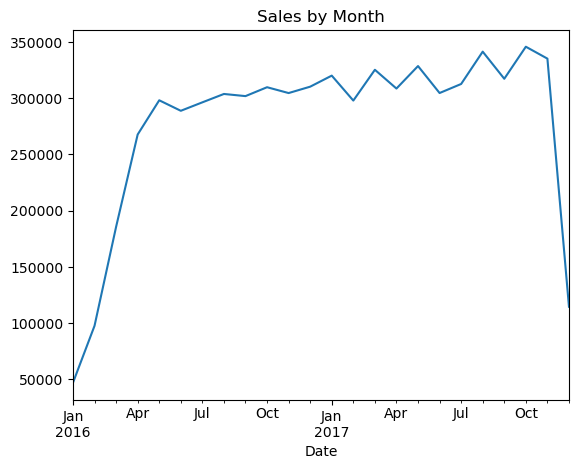

In [8]:
# plot Sales by Month
(transactions.set_index("Date")
.loc[:, "SALES_VALUE"]
.resample("M")
.sum()
.plot())
plt.title("Sales by Month")

because the plot is a little bit strange, and we don't have a full set of household observations. to give a better sense of trend, we should filter down the date

Text(0.5, 1.0, 'Sales by Month')

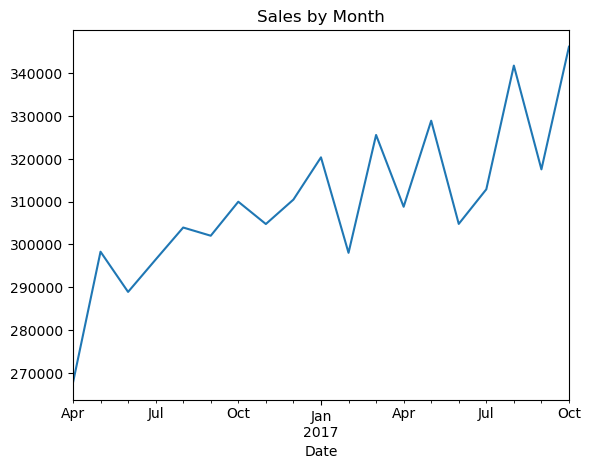

In [9]:
# to have clean monthly trend
(transactions.set_index("Date")
.loc["2016-04": "2017-10", "SALES_VALUE"]
.resample("M")
.sum()
.plot())
plt.title("Sales by Month")

nice steady growth month over month, which shows we have a healthy company

<Figure size 400x300 with 0 Axes>

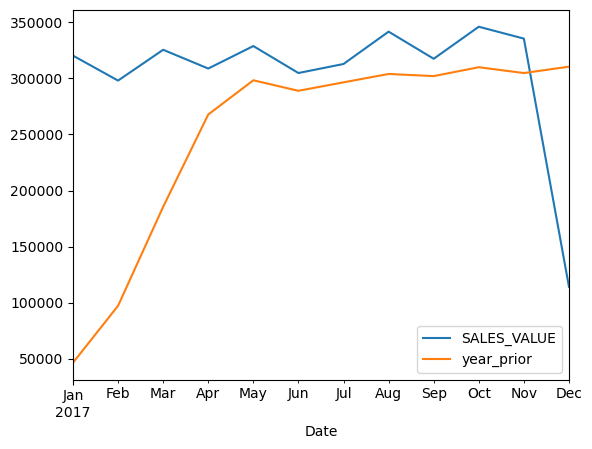

<Figure size 400x300 with 0 Axes>

In [10]:
# plot the Sales by Year
(transactions.set_index("Date")
.loc[ :, ["SALES_VALUE"]]
.resample("M")
.sum()
.assign(year_prior = lambda x: x["SALES_VALUE"].shift(12))    #creates a new column for the dataframe, year_prior, which shifts our date down by 12 to get year 
.loc["2017"]
.plot()
)
plt.figure(figsize=(4, 3))


ignoring the ramp of from Jan 2016 ( line orange ) and the sharp decline in the last month of 2017 ( line blue ), we can see clearly our overal of 2017 sales are higher than 2016. We also see a couple similar seasonal fluctuations that do look much stronger in 2017.

Text(0.5, 1.0, 'Total Sales by Week Day')

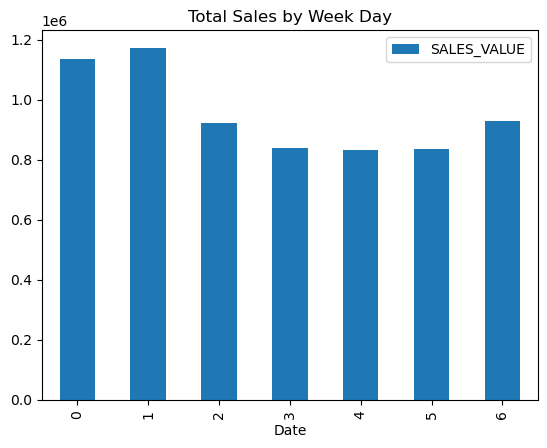

In [11]:
# total sales by week-day
# to get a better glamps into the behaviour of our acquisition target customer
(transactions.groupby(transactions["Date"].dt.day_of_week)
.agg({"SALES_VALUE" : "sum"})
.plot.bar())
plt.title("Total Sales by Week Day")

based on the bar chart, highest sales are on Monday and Tuesday followed by Sunday. It might be interesting to dive further into why more customers are coming in on these days.

### Demographics
We want to understand the composition of our customers and which are our strongest customer segments?

So, we're going to :
* Read in the hh_demographic.csv file, but only columns AGE_DESC, INCOME_DESC, household_key, and HH_COMP_DESC.
* Convert the appropriate columns to the category dtype.
* Group the transactions table by hosehold_id, and calculate the sum of Sales Value by household, and create aggregated household sales DataFrame.
* Join the demographics DataFrame to the aggregated transactions table. Since we're interested in analyzing the demographic data we have, make sure not to include rows from transactions that don't match.
* Plot the sum of sales by age_desc and income_desc, in seperate charts - to have a summary of total sales by these categories.
* Create a pivot table of the mean household sales by AGE_DESC and HH_COMP_DESC. 
* Finally, check Which of our demographic have the highest average sales? - to understand potential marketing strategies and complementary benefits with Maven own customer base.

In [12]:
# read in sub sets of the columns, then
# convert these column to category data type, to save ton of data for further join to transactions table, and having repeated column 
dem_cols = ["AGE_DESC", "INCOME_DESC", "household_key", "HH_COMP_DESC"]
dem_dtypes = {"AGE_DESC": "category", "INCOME_DESC": "category", "HH_COMP_DESC": "category"}
demographics = pd.read_csv("data/hh_demographic.csv", usecols=dem_cols, dtype=dem_dtypes)

In [13]:
demographics.head()

,AGE_DESC,INCOME_DESC,HH_COMP_DESC,household_key
0,65+,35-49K,2 Adults No Kids,1
1,45-54,50-74K,2 Adults No Kids,7
2,25-34,25-34K,2 Adults Kids,8
3,25-34,75-99K,2 Adults Kids,13
4,45-54,50-74K,Single Female,16


In [14]:
demographics.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   AGE_DESC       801 non-null    category
 1   INCOME_DESC    801 non-null    category
 2   HH_COMP_DESC   801 non-null    category
 3   household_key  801 non-null    int64   
dtypes: category(3), int64(1)
memory usage: 10.9 KB


In [15]:
# Sum of Sales by household
household_sales = transactions.groupby("household_key").agg({"SALES_VALUE" : "sum"})
household_sales.head(7)

,SALES_VALUE
household_key,
1,4330.16
2,1954.34
3,2653.21
4,1200.11
5,779.06
6,5996.16
7,3400.05


In [16]:
# join household table to demographic table, to analyze the demographics of our households
household_sales_demo = (household_sales.merge(demographics,
                        how="inner",
                        left_on= "household_key",
                        right_on= "household_key"
                        ))

In [17]:
household_sales_demo.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 0 to 667
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   household_key  668 non-null    int64   
 1   SALES_VALUE    668 non-null    float64 
 2   AGE_DESC       668 non-null    category
 3   INCOME_DESC    668 non-null    category
 4   HH_COMP_DESC   668 non-null    category
dtypes: category(3), float64(1), int64(1)
memory usage: 19.8 KB


we know have 668 households for analysis

Text(0.5, 0, 'Age Range')

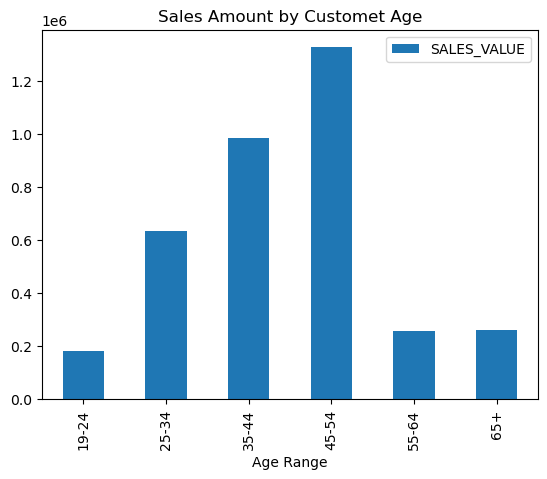

In [18]:
# plot the sum of sales value by age category
(household_sales_demo.groupby(["AGE_DESC"])
                     .agg({"SALES_VALUE": "sum"})
                     .plot.bar()
)
plt.title("Sales Amount by Customet Age")
plt.xlabel("Age Range")

Text(0.5, 0, 'Income Range')

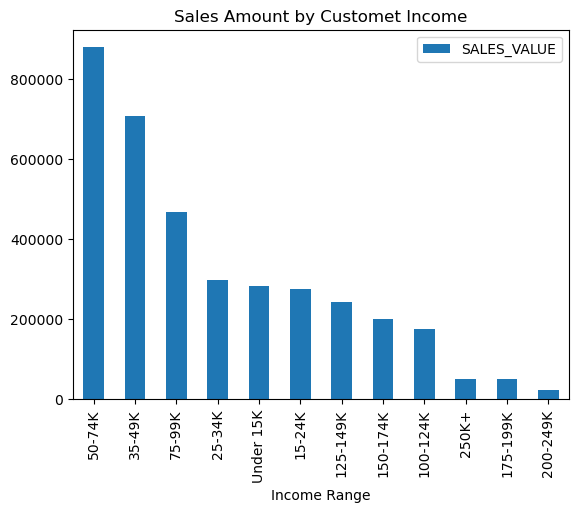

In [19]:
# plot the sum of sales value by income category
(household_sales_demo.groupby(["INCOME_DESC"])
                     .agg({"SALES_VALUE": "sum"})
                     .sort_values("SALES_VALUE", ascending=False)
                     .plot.bar()
)
plt.title("Sales Amount by Customet Income")
plt.xlabel("Income Range")

this is the most common household income demographis in the US, but it worth nothing that even our under-15K and 25-34K demographics are much higher than some of the higher income demographic. so, if we are looking at the discount retailor, it makes sense that we're attracting a lot of these lower income groups and this is expected by a leadership.

In [20]:
# create a pivot table and show the household composition by a heatmap
# this shows us which our demographic is producing the most revenue by household, and also aloow us to think about ways we can combine our strategy in terms of marketing with our aquisition targets
(household_sales_demo.pivot_table(index="AGE_DESC",
                                  columns="HH_COMP_DESC",
                                  values="SALES_VALUE",
                                  aggfunc="mean",
                                  margins=True)
                     .style.background_gradient(cmap="RdYlGn", axis=None)
)  

HH_COMP_DESC,1 Adult Kids,2 Adults Kids,2 Adults No Kids,Single Female,Single Male,Unknown,All
AGE_DESC,,,,,,,
19-24,7268.796667,5428.945000,4020.800000,4576.095556,3216.835000,4911.275000,4692.077692
25-34,5512.196875,5753.973514,5638.515833,4807.440588,4909.522381,7356.270000,5435.517521
35-44,6297.737778,6691.772264,6260.412444,6015.192069,4844.192000,4227.691818,6090.556728
45-54,6632.569167,6610.484490,5839.527027,4549.365405,4636.637083,4843.995682,5534.879958
55-64,3064.870000,4695.655000,5752.413684,4816.148462,3922.546250,7973.750000,5168.924200
65+,4040.810000,5536.866667,4614.108571,4059.699412,3871.556000,2879.290000,4340.936500
All,6032.802143,6280.069103,5599.857756,4895.928361,4544.646750,4936.127778,5468.398743


the heat-map shows that our average sales for single parent homes at a young age (19-24) have a very high sales. so, we should figure out how to help these single family homes as part of shopping experience. we might also look at focusing on families with children in general; is there a way that we can revamp our product distribution, is there a way that we can target our marketing more specificly towards these groups.

In [21]:
# we are done with two DataFrames, so, they should be deleted to save the memory
del [household_sales_demo, household_sales]

### Product Demographics

* Read in the product csv file.
* Only read in product_id and department from the product table.
* Join the product DataFrame to the original transactions and demographics tables, performing an inner join when joining both tables.
* Finally, pivot the fully joined dataframe by AGE_DESC and DEPARTMENT, calculating the sum of sales. 
* and take a look ate Which category is led by our youngest age demographic?

In [25]:
product_cols = ["PRODUCT_ID", "DEPARTMENT"]
product_dtypes = ({"PRODUCT_ID": "Int32",
                    "DEPARTMENT": "category"})

product = pd.read_csv("data/product.csv",
                        usecols=product_cols,
                        dtype=product_dtypes
                    )

product.head(7)

,PRODUCT_ID,DEPARTMENT
0,25671,GROCERY
1,26081,MISC. TRANS.
2,26093,PASTRY
3,26190,GROCERY
4,26355,GROCERY
5,26426,GROCERY
6,26540,GROCERY


In [27]:
# join all tables together
trans_demo_dept = (transactions.merge(demographics, how="inner", left_on="household_key", right_on="household_key")
                               .merge(product, how="inner", left_on="PRODUCT_ID", right_on="PRODUCT_ID")
                  )

trans_demo_dept.head()

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,Date,AGE_DESC,INCOME_DESC,HH_COMP_DESC,DEPARTMENT
0,1364,26984896261,842930,1,2.19,2016-01-01,65+,100-124K,Single Female,GROCERY
1,304,27950201718,842930,1,1.67,2016-03-21,25-34,50-74K,2 Adults No Kids,GROCERY
2,575,34186568032,842930,1,1.67,2017-04-29,35-44,50-74K,Single Female,GROCERY
3,77,28023861855,842930,3,5.00,2016-03-27,35-44,100-124K,2 Adults Kids,GROCERY
4,454,42136182098,842930,1,1.67,2017-11-29,55-64,35-49K,Single Male,GROCERY


In [28]:
trans_demo_dept.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1161575 entries, 0 to 1161574
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   household_key  1161575 non-null  int64         
 1   BASKET_ID      1161575 non-null  int64         
 2   PRODUCT_ID     1161575 non-null  int64         
 3   QUANTITY       1161575 non-null  Int32         
 4   SALES_VALUE    1161575 non-null  float64       
 5   Date           1161575 non-null  datetime64[ns]
 6   AGE_DESC       1161575 non-null  category      
 7   INCOME_DESC    1161575 non-null  category      
 8   HH_COMP_DESC   1161575 non-null  category      
 9   DEPARTMENT     1161575 non-null  category      
dtypes: Int32(1), category(4), datetime64[ns](1), float64(1), int64(3)
memory usage: 63.1 MB


In [29]:
# creating the pivit table, on department by age
# to look at the areas among young customers
# are they going to be our next generation of customers for the company?
(trans_demo_dept.pivot_table(
    index="DEPARTMENT", 
    columns="AGE_DESC",
    values="SALES_VALUE",
    aggfunc="sum"
    ).style.background_gradient(cmap="RdYlGn", axis=1)
)

AGE_DESC,19-24,25-34,35-44,45-54,55-64,65+
DEPARTMENT,,,,,,
,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AUTOMOTIVE,11.640000,21.250000,72.580000,55.920000,0.000000,16.370000
CHARITABLE CONT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHEF SHOPPE,81.300000,134.160000,348.530000,418.240000,80.860000,149.240000
CNTRL/STORE SUP,2.000000,0.000000,1.000000,9.950000,2.000000,0.100000
COSMETICS,698.630000,2273.030000,4362.020000,5187.570000,986.260000,600.900000
COUP/STR & MFG,7.490000,48.420000,121.200000,154.550000,40.680000,20.490000
DAIRY DELI,3.800000,3.850000,7.390000,16.750000,3.140000,1.940000
DELI,4043.300000,18181.940000,34577.290000,44334.220000,9850.540000,10462.330000


In [ ]:
# the young customers are interested in SPIRITS ( alcohol ) 

### Export
Finally, export the pivot table to an excel file. Make sure to provide a sheet name.

In [30]:
(trans_demo_dept.pivot_table(
                            index="DEPARTMENT",
                            columns="AGE_DESC",
                            values="SALES_VALUE",
                            aggfunc="sum"
                            ).style.background_gradient(cmap="RdYlGn", axis=1)
                            .to_excel("demographic_category_sales.xlsx", sheet_name="sales_pivot")
)